<a href="https://colab.research.google.com/github/Derinhelm/parser_stat/blob/main/Russian_parser_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачивание SynTagRus (тестовая часть)

In [ ]:
from google.colab import output

In [ ]:
!wget -m https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu
!mv /content/raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu /content/ru_syntagrus-ud-test.conllu
!rm -r /content/raw.githubusercontent.com
output.clear()

# Получение информации из SynTagRus

In [ ]:
class ConllEntry:
    def __init__(self, id, form=None, lemma=None, pos=None, cpos=None, feats=None, \
                 parent_id=None, relation=None,deps=None, misc=None):
        self.id = id
        self.form = form
        self.lemma = lemma
        self.pos = pos
        self.cpos = cpos
        self.feats = feats
        self.parent_id = parent_id
        self.relation = relation
        self.deps = deps
        self.misc = misc

In [ ]:
class Sentence:
    def __init__(self):
        self.text = ""
        self.sent_id = ""
        self.tokens = []

    def add_token(self, token):
        self.tokens.append(token)

    def set_sent_id(self, sent_id):
        self.sent_id = sent_id

    def set_text(self, text):
        self.text = text

    def is_not_empty(self):
        return len(self.tokens) > 0

In [ ]:
def get_dataset_sentences(dataset_path):
    fh = open(dataset_path,'r',encoding='utf-8')
    sents_read = 0
    sents = []
    comments = set()

    sent = Sentence()
    for line in fh:
        tok = line.strip().split('\t')
        if not tok or line.strip() == '': # empty line, add sentence to list
            if sent.is_not_empty:
                sents_read += 1
                sents.append(sent)
            sent = Sentence()
        else:
            if line[0] == '#' or '-' in tok[0]: # a comment line
                line = line.strip()
                if line[:12] == "# sent_id = ":
                    sent.set_sent_id(line[12:])
                elif line[:9] == "# text = ":
                    sent.set_text(line[9:])
                else:
                    comments.add(line)

            else: # an actual ConllEntry, add to tokens
                if tok[2] == "_":
                    tok[2] = tok[1].lower()
                if not "." in tok[0]:
                    token = ConllEntry(*tok)
                    sent.add_token(token)
    fh.close()
    return sents

In [ ]:
all_sents = get_dataset_sentences("/content/ru_syntagrus-ud-test.conllu")

In [ ]:
len(all_sents)

8800

Проверка, что все sent_id в тестовой выборке датасета разные.

In [ ]:
len({s.sent_id for s in all_sents}) == len(all_sents)

True

In [ ]:
from collections import OrderedDict
sents = OrderedDict()
for s in all_sents:
  sents[s.sent_id] = s

In [ ]:
len(sents)

8800

# Загрузка результатов

In [ ]:
!wget -m https://github.com/Derinhelm/parser_stat/raw/main/pickle_results/deeppavlov_parsing.pickle
!wget -m https://github.com/Derinhelm/parser_stat/raw/main/pickle_results/natasha_parsing.pickle
!wget -m https://github.com/Derinhelm/parser_stat/raw/main/pickle_results/spacy_parsing.pickle
!wget -m https://github.com/Derinhelm/parser_stat/raw/main/pickle_results/stanza_parsing.pickle
!wget -m https://github.com/Derinhelm/parser_stat/raw/main/pickle_results/udpipe_parsing.pickle
!mv /content/github.com/Derinhelm/parser_stat/raw/main/pickle_results/* /content/
!rm -r /content/github.com
output.clear()

In [ ]:
parser_names = ["udpipe", "stanza", "natasha", "deeppavlov", "spacy"]

In [ ]:
res = {}

In [ ]:
import pickle

In [ ]:
pickle_res = {}
for p in parser_names:
    with open(p + '_parsing.pickle', 'rb') as f:
       pickle_res[p] = pickle.load(f)

In [ ]:
res = {p: OrderedDict() for p in parser_names}
for p in parser_names:
  for s in pickle_res[p]:
      res[p][s.sent_id] = s

In [ ]:
for p in parser_names:
  print(p, len(res[p]))

udpipe 8800
stanza 8800
natasha 8800
deeppavlov 8800
spacy 8800


# Creating token start-end pairs

In [ ]:
def create_begin_end_list(sent_text_dict, token_sent_dict):
  token_begin_end_dict = {}
  for sent_id, sent_text_val in sent_text_dict.items():
    token_begin_end = []
    sent_text = sent_text_val.lower()
    del_prefix_len = 0
    tokens = token_sent_dict[sent_id]
    for t_i, t in enumerate(tokens):
      token_text = t.lower().replace('``', '"').replace("''", '"')
      t_start = sent_text.find(token_text)
      if t_start == -1:
        print("Error:", sent_id, f"sent_text:{sent_text}, t:{token_text}", t_i)
      else:
        token_begin_end.append((del_prefix_len + t_start,
                              del_prefix_len + t_start + len(token_text)))
        del_prefix_len += t_start + len(token_text)
        sent_text = sent_text[t_start + len(token_text):]
    for i, (b, f) in enumerate(token_begin_end):
      assert sent_text_val[b:f].lower() == tokens[i].lower().replace('``', '"').replace("''", '"')
    token_begin_end_dict[sent_id] = token_begin_end
  assert len(token_begin_end_dict) == len(sent_text_dict)
  assert len(token_begin_end_dict) == len(token_sent_dict)
  return token_begin_end_dict

In [ ]:
sent_id_list = list(sents.keys())

syntagrus_begin_end_list = create_begin_end_list({sent_id: sents[sent_id].text for sent_id in sent_id_list},
                                                 {sent_id:[w.form for w in sents[sent_id].tokens] for sent_id in sent_id_list})
print(len(syntagrus_begin_end_list))

8800


In [ ]:
syntagrus_begin_end_list['2003Armeniya.xml_11']

[(0, 1),
 (2, 9),
 (10, 21),
 (22, 27),
 (27, 28),
 (29, 39),
 (40, 52),
 (53, 64),
 (64, 65)]

In [ ]:
res_begin_end_list = {}
for p in parser_names:
  res_begin_end_list[p] = create_begin_end_list({sent_id:sents[sent_id].text for sent_id in sent_id_list},
                                                 {sent_id: [w.form for w in res[p][sent_id].tokens]
                                                    for sent_id in sent_id_list})
  print(p, len(res_begin_end_list[p]))

udpipe 8800
stanza 8800
natasha 8800
deeppavlov 8800
spacy 8800


In [ ]:
be_res = {p: {} for p in parser_names}
for p in parser_names:
  for sent_id in sent_id_list:
    sent_be_res = OrderedDict()
    for t_i, t in enumerate(res[p][sent_id].tokens):
      child_be = res_begin_end_list[p][sent_id][t_i]
      parent = t.parent_id
      if parent == '0': # root
        parent_be = (-1, -1)
      else:
        parent_be = res_begin_end_list[p][sent_id][int(parent) - 1]
      sent_be_res[child_be] = (parent_be, t.relation)
    be_res[p][sent_id] = sent_be_res
    assert len(be_res[p][sent_id]) == len(res[p][sent_id].tokens)
  assert len(be_res[p]) == len(res[p])

In [ ]:
be_syntagrus = {}
for sent_id in sent_id_list:
  sent_be_syntagrus = OrderedDict()
  for t_i, t in enumerate(sents[sent_id].tokens):
    child_be = syntagrus_begin_end_list[sent_id][t_i]
    parent = t.parent_id
    if parent == '0': # root
      parent_be = (-1, -1)
    else:
      parent_be = syntagrus_begin_end_list[sent_id][int(parent) - 1]
    sent_be_syntagrus[child_be] = (parent_be, t.relation)
  be_syntagrus[sent_id] = sent_be_syntagrus
  assert len(be_syntagrus[sent_id]) == len(sents[sent_id].tokens)
assert len(be_syntagrus) == len(sents)

In [ ]:
be_syntagrus['2003Artist_mimansa.xml_130']

OrderedDict([((0, 2), ((16, 20), 'nsubj')),
             ((3, 15), ((16, 20), 'advmod')),
             ((16, 20), ((-1, -1), 'root')),
             ((21, 24), ((25, 34), 'det')),
             ((25, 34), ((16, 20), 'obj')),
             ((35, 43), ((16, 20), 'advmod')),
             ((43, 44), ((16, 20), 'punct'))])

In [ ]:
be_res['stanza']['2003Artist_mimansa.xml_130']

OrderedDict([((0, 2), ((16, 20), 'nsubj')),
             ((3, 9), ((16, 20), 'obl')),
             ((9, 10), ((10, 15), 'punct')),
             ((10, 15), ((3, 9), 'conj')),
             ((16, 20), ((-1, -1), 'root')),
             ((21, 24), ((25, 34), 'det')),
             ((25, 34), ((16, 20), 'obj')),
             ((35, 43), ((16, 20), 'advmod')),
             ((43, 44), ((16, 20), 'punct'))])

# Sentence statistics

In [ ]:
import pandas as pd

stat = {}
for p in parser_names:
  stat_list = []
  for sent_id in be_syntagrus:
    extra_syntagrus = len(be_syntagrus[sent_id].keys() - be_res[p][sent_id].keys())
    extra_parser = len(be_res[p][sent_id].keys() - be_syntagrus[sent_id].keys())
    tokenisation_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()})
    parent_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()
      if be_res[p][sent_id][t_be][0] == be_syntagrus[sent_id][t_be][0]})
    relation_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()
      if be_res[p][sent_id][t_be] == be_syntagrus[sent_id][t_be]})
    stat_list.append((sent_id, extra_syntagrus, extra_parser, tokenisation_matched,
                      parent_matched, relation_matched, len(sents[sent_id].tokens)))
  stat[p] = pd.DataFrame(stat_list, columns=['sent_id', 'extra_syntagrus', 'extra_parser', 'tokenisation_matched',
                                             'parent_matched', 'relation_matched', 'token_length'])

In [ ]:
from collections import Counter

In [ ]:
align_uas_f = {}
align_las_f = {}
for p in parser_names:
  align_uas_precision = stat[p]['parent_matched'] / (stat[p]['extra_parser'] + stat[p]['tokenisation_matched'])
  align_uas_recall = stat[p]['parent_matched'] / (stat[p]['extra_syntagrus'] + stat[p]['tokenisation_matched'])
  align_las_precision = stat[p]['relation_matched'] / (stat[p]['extra_parser'] + stat[p]['tokenisation_matched'])
  align_las_recall = stat[p]['relation_matched'] / (stat[p]['extra_syntagrus'] + stat[p]['tokenisation_matched'])
  align_uas_f[p] = ((2 * align_uas_precision * align_uas_recall) / (align_uas_precision + align_uas_recall)).fillna(0.0)
  align_las_f[p] = ((2 * align_las_precision * align_las_recall) / (align_las_precision + align_las_recall)).fillna(0.0)
align_res = {"uas_f": align_uas_f,
             "las_f": align_las_f}

In [ ]:
for p in parser_names:
  print(p, end = ". ")
  for a_res in align_res:
    print(f"{a_res}:{align_res[a_res][p].mean():.2f}", end = ", ")
  print()

udpipe. uas_f:0.88, las_f:0.84, 
stanza. uas_f:0.92, las_f:0.90, 
natasha. uas_f:0.83, las_f:0.78, 
deeppavlov. uas_f:0.92, las_f:0.89, 
spacy. uas_f:0.87, las_f:0.82, 


## F1-score

##Mean values of sentence f-score

In [ ]:
for p in parser_names:
  p1 = p + "."
  print(f"{p1:11}", end = " ")
  for score_dict, title in [(align_uas_f, 'uas_f'), (align_las_f, 'las_f')]:
    print(f"{title}:{score_dict[p].mean():.2f}", end = ", ")
  print()

udpipe.     uas_f:0.88, las_f:0.84, 
stanza.     uas_f:0.92, las_f:0.90, 
natasha.    uas_f:0.83, las_f:0.78, 
deeppavlov. uas_f:0.92, las_f:0.89, 
spacy.      uas_f:0.87, las_f:0.82, 


##Std values of sentence f-score

In [ ]:
for p in parser_names:
  p1 = p + "."
  print(f"{p1:11}", end = " ")
  for score_dict, title in [(align_uas_f, 'uas_f'), (align_las_f, 'las_f')]:
    print(f"{title}:{score_dict[p].std():.2f}", end = ", ")
  print()

udpipe.     uas_f:0.16, las_f:0.17, 
stanza.     uas_f:0.16, las_f:0.17, 
natasha.    uas_f:0.17, las_f:0.18, 
deeppavlov. uas_f:0.13, las_f:0.14, 
spacy.      uas_f:0.17, las_f:0.18, 


##UAS/LAS=0.0

In [ ]:
for p in parser_names:
  print(p, sum(align_uas_f[p] == 0.0))

udpipe 21
stanza 26
natasha 31
deeppavlov 31
spacy 29


In [ ]:
for p in parser_names:
  print(p, sum(align_las_f[p] == 0.0))

udpipe 25
stanza 27
natasha 36
deeppavlov 35
spacy 35


## UAS/LAS=1.0

In [ ]:
for p in parser_names:
  print(p, sum(align_uas_f[p] == 1.0), round(sum(align_uas_f[p] == 1.0) / len(sents), 2))

udpipe 3375 0.38
stanza 4708 0.54
natasha 2397 0.27
deeppavlov 4472 0.51
spacy 3159 0.36


In [ ]:
for p in parser_names:
  print(p, sum(align_las_f[p] == 1.0), round(sum(align_las_f[p] == 1.0) / len(sents), 2))

udpipe 2279 0.26
stanza 3606 0.41
natasha 1601 0.18
deeppavlov 3247 0.37
spacy 1920 0.22


## Distributions

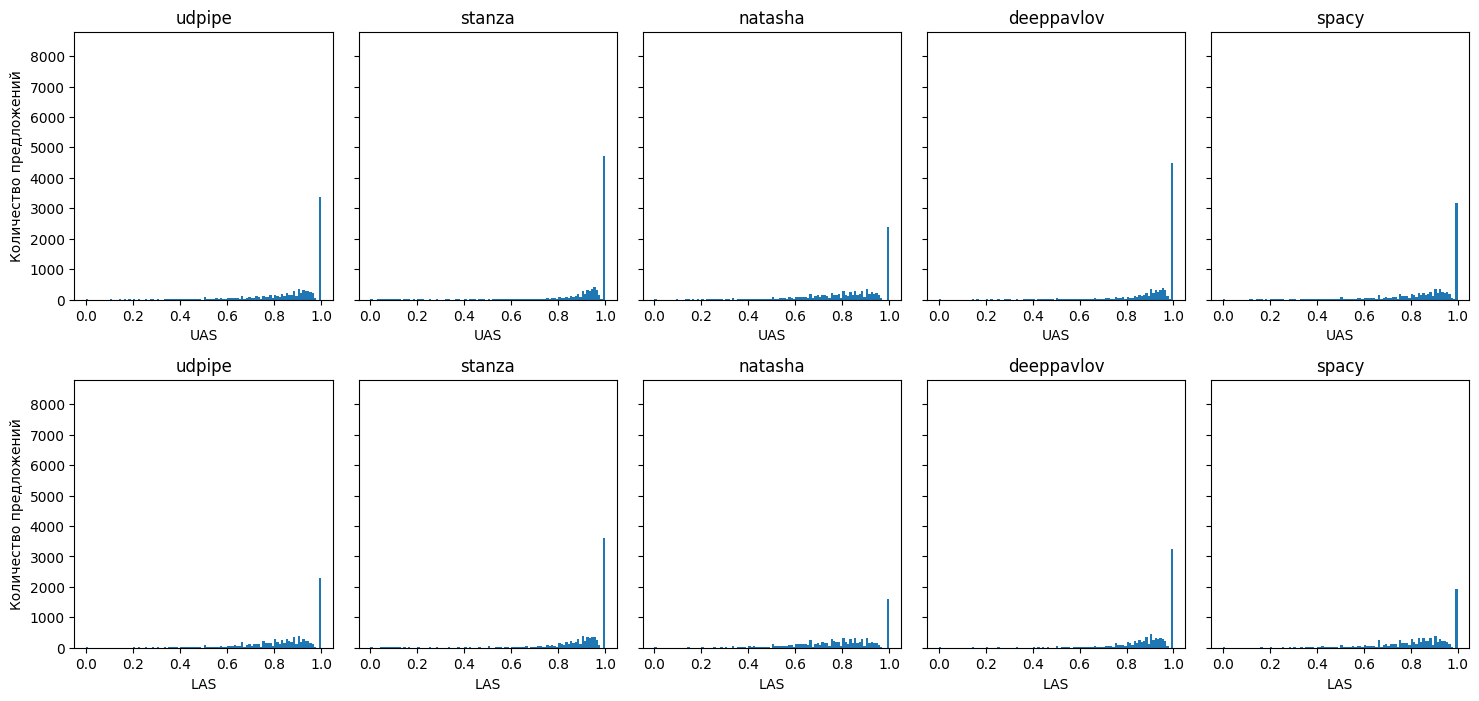

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols= len(parser_names), figsize = (18,8), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

#fig.suptitle('aligned uas/aligned las (f-score)')

for parser_i, p in enumerate(parser_names):
    ax[0, parser_i].hist([r for r in align_uas_f[p]], bins=100)
    ax[0, parser_i].title.set_text(p)
    ax[0, parser_i].set_xlabel('UAS')

    ax[1, parser_i].hist([r for r in align_las_f[p]], bins=100)
    ax[1, parser_i].title.set_text(p)
    ax[1, parser_i].set_xlabel('LAS')


ax[0, 0].set_ylabel('Количество предложений')
ax[1, 0].set_ylabel('Количество предложений')


plt.ylim([0, len(sents)])
plt.savefig('uas_las_distributions.jpg')
plt.show()

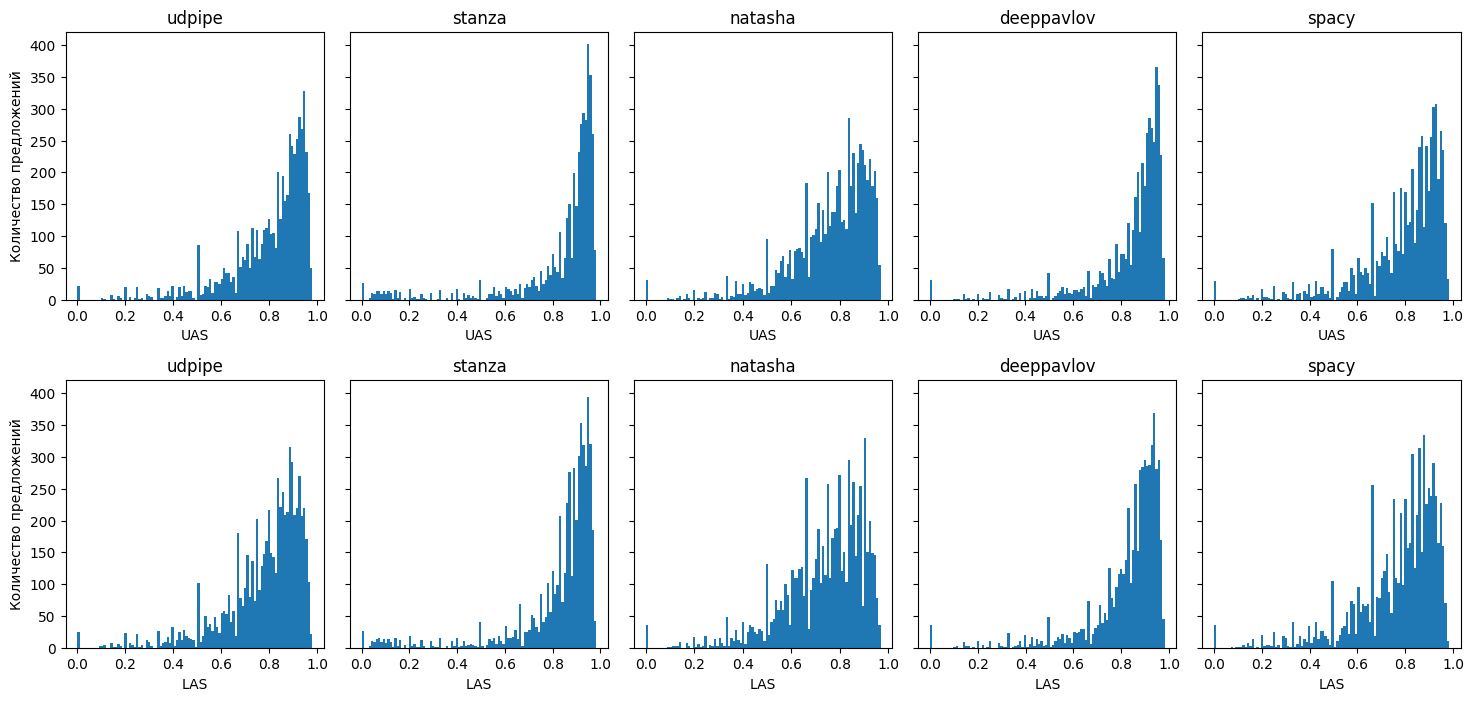

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols= len(parser_names), figsize = (18,8), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

#fig.suptitle('aligned uas/aligned las (f-score), without UAS/LAS=1.0')

for parser_i, p in enumerate(parser_names):
    ax[0, parser_i].hist([r for r in align_uas_f[p] if r != 1.0], bins=100)
    ax[0, parser_i].title.set_text(p)
    ax[0, parser_i].set_xlabel('UAS')
    ax[1, parser_i].hist([r for r in align_las_f[p] if r != 1.0], bins=100)
    ax[1, parser_i].title.set_text(p)
    ax[1, parser_i].set_xlabel('LAS')

ax[0, 0].set_ylabel('Количество предложений')
ax[1, 0].set_ylabel('Количество предложений')

plt.savefig('uas_las_distributions_without1.0.jpg')
plt.show()

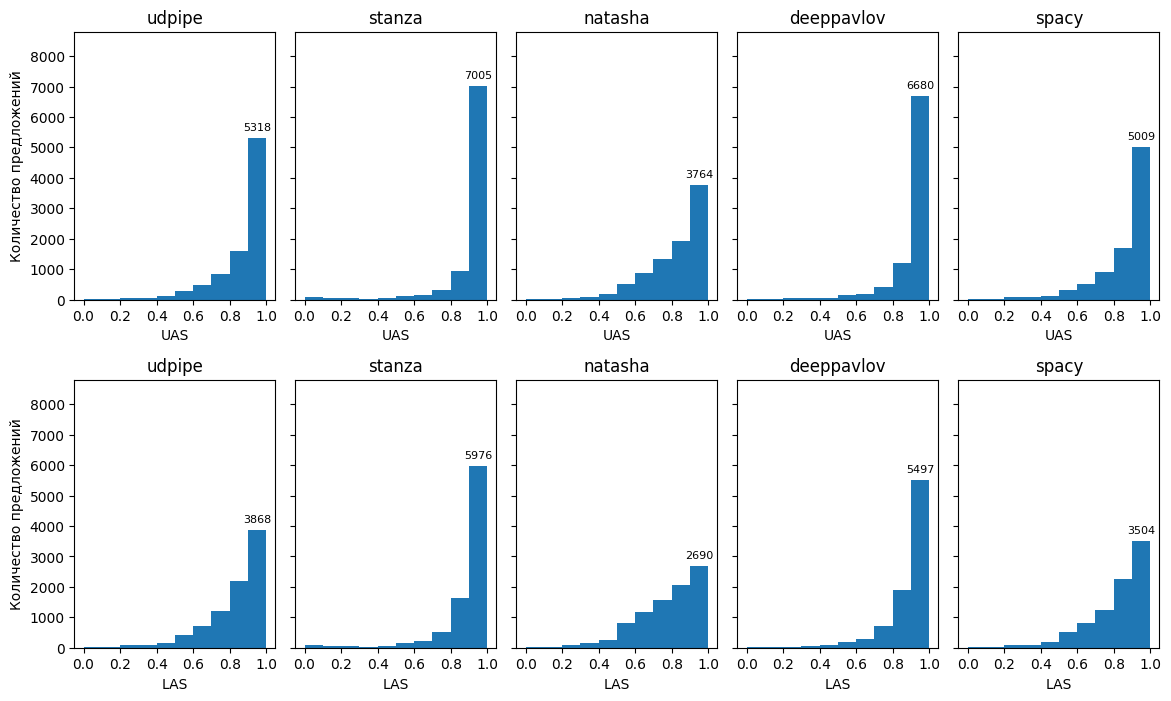

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=2, ncols= len(parser_names), figsize = (14,8), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#fig.suptitle('aligned uas/aligned las (f-score)')
uas10 = {}
las10 = {}

for parser_i, p in enumerate(parser_names):
    h = ax[0, parser_i].hist([r for r in align_uas_f[p]], bins=10)
    for q_i in range(len(h[0])):
      if h[0][q_i] > 3000:
        ax[0, parser_i].text(
          h[1][q_i] + 0.05, # x-coordinate
          h[0][q_i] + 250, # y-coordinate
          f'{h[0][q_i]:.0f}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
       )
    uas10[p] = h[0]
    ax[0, parser_i].title.set_text(p)
    ax[0, parser_i].set_ylim([0, len(sents)])
    ax[0, parser_i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax[0, parser_i].set_xlabel('UAS')
    h = ax[1, parser_i].hist([r for r in align_las_f[p]], bins=10)
    las10[p] = h[0]
    for q_i in range(len(h[0])):
      if h[0][q_i] > 3000 or h[1][q_i] == 0.9:
        ax[1, parser_i].text(
          h[1][q_i] + 0.05, # x-coordinate
          h[0][q_i] + 250, # y-coordinate
          f'{h[0][q_i]:.0f}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
       )
    ax[1, parser_i].title.set_text(p)
    ax[1, parser_i].set_ylim([0, len(sents)])
    ax[1, parser_i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax[1, parser_i].set_xlabel('LAS')
ax[0, 0].set_ylabel('Количество предложений')
ax[1, 0].set_ylabel('Количество предложений')
plt.ylim(0, len(sents))
plt.savefig('uas_las_distributions10.jpg')
plt.show()

In [ ]:
print("UAS")
print(" " * 10, end=" ")
for i in range(10):
  print(f" {i * 0.1:.1f}-{(i + 1) * 0.1:.1f}  |", end=" ")
print()
for p in parser_names:
  print(f"{p:10}", end=" ")
  for q in uas10[p]:
    print(f"{q:4.0f} ({(q / len(sents) * 100):2.0f}%)|", end=" ")
  print()

UAS
            0.0-0.1  |  0.1-0.2  |  0.2-0.3  |  0.3-0.4  |  0.4-0.5  |  0.5-0.6  |  0.6-0.7  |  0.7-0.8  |  0.8-0.9  |  0.9-1.0  | 
udpipe       21 ( 0%)|   21 ( 0%)|   61 ( 1%)|   53 ( 1%)|  113 ( 1%)|  294 ( 3%)|  486 ( 6%)|  829 ( 9%)| 1604 (18%)| 5318 (60%)| 
stanza       96 ( 1%)|   66 ( 1%)|   48 ( 1%)|   29 ( 0%)|   49 ( 1%)|  117 ( 1%)|  145 ( 2%)|  309 ( 4%)|  936 (11%)| 7005 (80%)| 
natasha      33 ( 0%)|   20 ( 0%)|   57 ( 1%)|   99 ( 1%)|  169 ( 2%)|  527 ( 6%)|  886 (10%)| 1326 (15%)| 1919 (22%)| 3764 (43%)| 
deeppavlov   31 ( 0%)|   16 ( 0%)|   35 ( 0%)|   35 ( 0%)|   65 ( 1%)|  149 ( 2%)|  172 ( 2%)|  421 ( 5%)| 1196 (14%)| 6680 (76%)| 
spacy        29 ( 0%)|   26 ( 0%)|   70 ( 1%)|   74 ( 1%)|  133 ( 2%)|  326 ( 4%)|  519 ( 6%)|  914 (10%)| 1700 (19%)| 5009 (57%)| 


In [ ]:
print("LAS")
print(" " * 10, end=" ")
for i in range(10):
  print(f" {i * 0.1:.1f}-{(i + 1) * 0.1:.1f}  |", end=" ")
print()
for p in parser_names:
  print(f"{p:10}", end=" ")
  for q in las10[p]:
    print(f"{q:4.0f} ({(q / len(sents) * 100):2.0f}%)|", end=" ")
  print()

LAS
            0.0-0.1  |  0.1-0.2  |  0.2-0.3  |  0.3-0.4  |  0.4-0.5  |  0.5-0.6  |  0.6-0.7  |  0.7-0.8  |  0.8-0.9  |  0.9-1.0  | 
udpipe       27 ( 0%)|   24 ( 0%)|   82 ( 1%)|   75 ( 1%)|  171 ( 2%)|  432 ( 5%)|  709 ( 8%)| 1214 (14%)| 2198 (25%)| 3868 (44%)| 
stanza      100 ( 1%)|   65 ( 1%)|   57 ( 1%)|   33 ( 0%)|   49 ( 1%)|  154 ( 2%)|  236 ( 3%)|  502 ( 6%)| 1628 (18%)| 5976 (68%)| 
natasha      37 ( 0%)|   25 ( 0%)|   80 ( 1%)|  140 ( 2%)|  254 ( 3%)|  801 ( 9%)| 1167 (13%)| 1561 (18%)| 2045 (23%)| 2690 (31%)| 
deeppavlov   35 ( 0%)|   18 ( 0%)|   38 ( 0%)|   47 ( 1%)|   82 ( 1%)|  184 ( 2%)|  277 ( 3%)|  712 ( 8%)| 1910 (22%)| 5497 (62%)| 
spacy        37 ( 0%)|   31 ( 0%)|   96 ( 1%)|   98 ( 1%)|  204 ( 2%)|  509 ( 6%)|  820 ( 9%)| 1235 (14%)| 2266 (26%)| 3504 (40%)| 


In [ ]:
print(f" " * 22 + " " * 5 + ">" + " " * 5 + "|" + " " * 6 + "<" + " " * 6 + "|" + " " * 6 + "=" + " " * 6 + "|")
for i, p1 in enumerate(parser_names):
  for p2 in parser_names[i+1:]:
    print(f"{p1:10}", f"{p2:10}", f"{sum(align_uas_f[p1] > align_uas_f[p2]):4}", f"{sum(align_uas_f[p1] > align_uas_f[p2]) / len(sents) * 100:4.0f}% | ",
          f"{sum(align_uas_f[p1] < align_uas_f[p2]):4}", f"{sum(align_uas_f[p1] < align_uas_f[p2]) / len(sents) * 100:4.0f}% | ",
          f"{sum(align_uas_f[p1] == align_uas_f[p2]):4}", f"{sum(align_uas_f[p1] == align_uas_f[p2]) / len(sents) * 100:4.0f}% | ")

                           >     |      <      |      =      |
udpipe     stanza      886   10% |  3771   43% |  4143   47% | 
udpipe     natasha    4237   48% |  1731   20% |  2832   32% | 
udpipe     deeppavlov 1217   14% |  3716   42% |  3867   44% | 
udpipe     spacy      2765   31% |  2657   30% |  3378   38% | 
stanza     natasha    5257   60% |   674    8% |  2869   33% | 
stanza     deeppavlov 2252   26% |  1744   20% |  4804   55% | 
stanza     spacy      3980   45% |   921   10% |  3899   44% | 
natasha    deeppavlov  629    7% |  5233   59% |  2938   33% | 
natasha    spacy      1679   19% |  4197   48% |  2924   33% | 
deeppavlov spacy      3887   44% |  1145   13% |  3768   43% | 


In [ ]:
p1 = parser_names[0]
p2 = parser_names[1]
ser = align_uas_f[p1] == align_uas_f[p2]
for p in parser_names[2:]:
  ser = ser & (align_uas_f[p1] == align_uas_f[p])
print(sum(ser))

1610


In [ ]:
print(f" " * 22 + " " * 5 + ">" + " " * 5 + "|" + " " * 6 + "<" + " " * 6 + "|" + " " * 6 + "=" + " " * 6 + "|")
for i, p1 in enumerate(parser_names):
  for p2 in parser_names[i+1:]:
    print(f"{p1:10}", f"{p2:10}",
              f"{sum(align_las_f[p1] > align_las_f[p2]):4}", f"{sum(align_las_f[p1] > align_las_f[p2]) / len(sents) * 100:4.0f}% | ",
              f"{sum(align_las_f[p1] < align_las_f[p2]):4}", f"{sum(align_las_f[p1] < align_las_f[p2]) / len(sents) * 100:4.0f}% | ",
              sum(align_las_f[p1] == align_las_f[p2]), f"{sum(align_las_f[p1] == align_las_f[p2]) / len(sents) * 100:4.0f}% | ")

                           >     |      <      |      =      |
udpipe     stanza      906   10% |  4682   53% |  3212   36% | 
udpipe     natasha    4487   51% |  2039   23% |  2274   26% | 
udpipe     deeppavlov 1196   14% |  4335   49% |  3269   37% | 
udpipe     spacy      3328   38% |  2949   34% |  2523   29% | 
stanza     natasha    5838   66% |   725    8% |  2237   25% | 
stanza     deeppavlov 2906   33% |  1943   22% |  3951   45% | 
stanza     spacy      5015   57% |  1031   12% |  2754   31% | 
natasha    deeppavlov  821    9% |  5741   65% |  2238   25% | 
natasha    spacy      1943   22% |  4253   48% |  2604   30% | 
deeppavlov spacy      4832   55% |  1366   16% |  2602   30% | 


In [ ]:
p1 = parser_names[0]
p2 = parser_names[1]
ser = align_las_f[p1] == align_las_f[p2]
for p in parser_names[2:]:
  ser = ser & (align_las_f[p1] == align_las_f[p])
print(sum(ser))

940


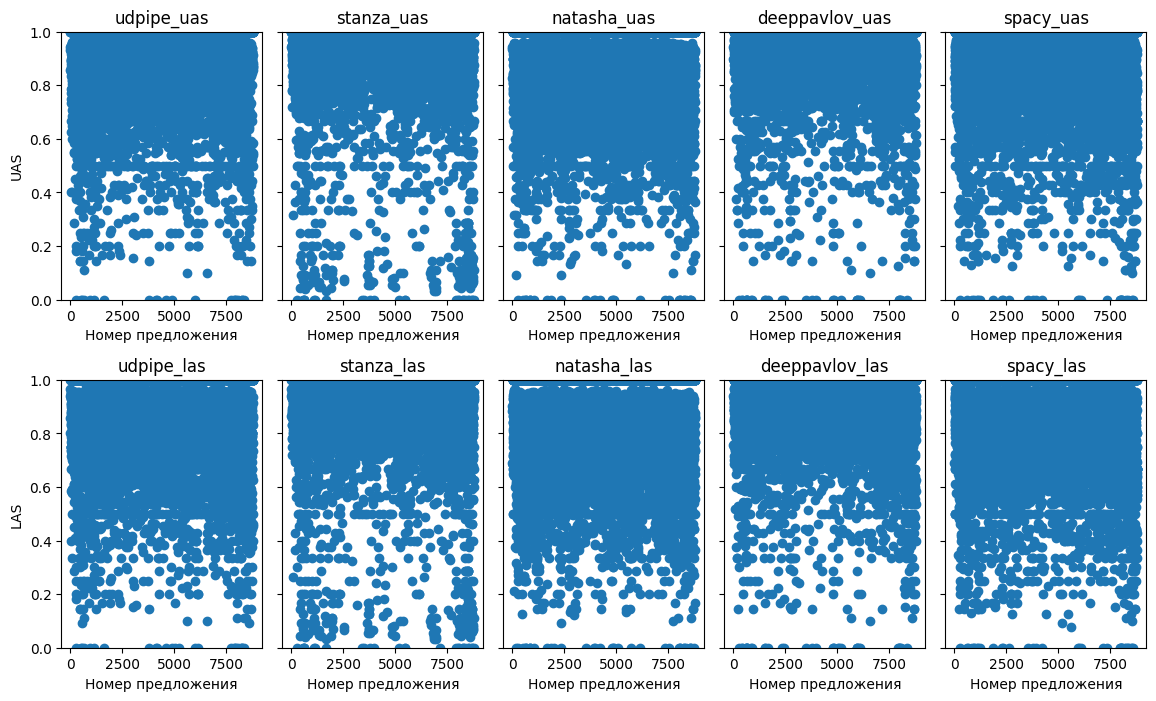

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(nrows=2, ncols= len(parser_names), figsize = (14,8), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#fig.suptitle('aligned uas/aligned las (f-score)')

for parser_i, p in enumerate(parser_names):
    ax[0, parser_i].plot(range(8800), [align_uas_f[p][i] for i in range(8800)], 'o')
    ax[0, parser_i].title.set_text(f"{p}_uas")
    ax[0, parser_i].set_ylim([0, 1.0])
    ax[0, parser_i].set_xlabel('Номер предложения')
    ax[1, parser_i].plot(range(8800), [align_las_f[p][i] for i in range(8800)], 'o')
    ax[1, parser_i].title.set_text(f"{p}_las")
    ax[1, parser_i].set_ylim([0, 1.0])
    ax[1, parser_i].set_xlabel('Номер предложения')
ax[0, 0].set_ylabel('UAS')
ax[1, 0].set_ylabel('LAS')
plt.savefig('uas_las_distributions_points.jpg')
plt.show()

## UAS/LAS quantilies

In [ ]:
for p in parser_names:
  print(p, round(align_uas_f[p].quantile(0.25), 2),
        round(align_uas_f[p].quantile(0.5), 2),
        round(align_uas_f[p].quantile(0.75), 2))

udpipe 0.82 0.93 1.0
stanza 0.92 1.0 1.0
natasha 0.73 0.86 1.0
deeppavlov 0.9 1.0 1.0
spacy 0.8 0.92 1.0


In [ ]:
for p in parser_names:
  print(p, round(align_las_f[p].quantile(0.25), 2),
        round(align_las_f[p].quantile(0.5), 2),
        round(align_las_f[p].quantile(0.75), 2))

udpipe 0.76 0.88 1.0
stanza 0.87 0.95 1.0
natasha 0.67 0.81 0.92
deeppavlov 0.85 0.93 1.0
spacy 0.74 0.86 0.95


In [ ]:
# IRQ for UAS
for p in parser_names:
  print(p, f"{align_uas_f[p].quantile(0.75) - align_uas_f[p].quantile(0.25):.2f}")

udpipe 0.18
stanza 0.08
natasha 0.27
deeppavlov 0.10
spacy 0.20


In [ ]:
# IRQ for LAS
for p in parser_names:
  print(p, f"{align_las_f[p].quantile(0.75) - align_las_f[p].quantile(0.25):.2f}")

udpipe 0.24
stanza 0.13
natasha 0.25
deeppavlov 0.15
spacy 0.21


## Distribution boxplot

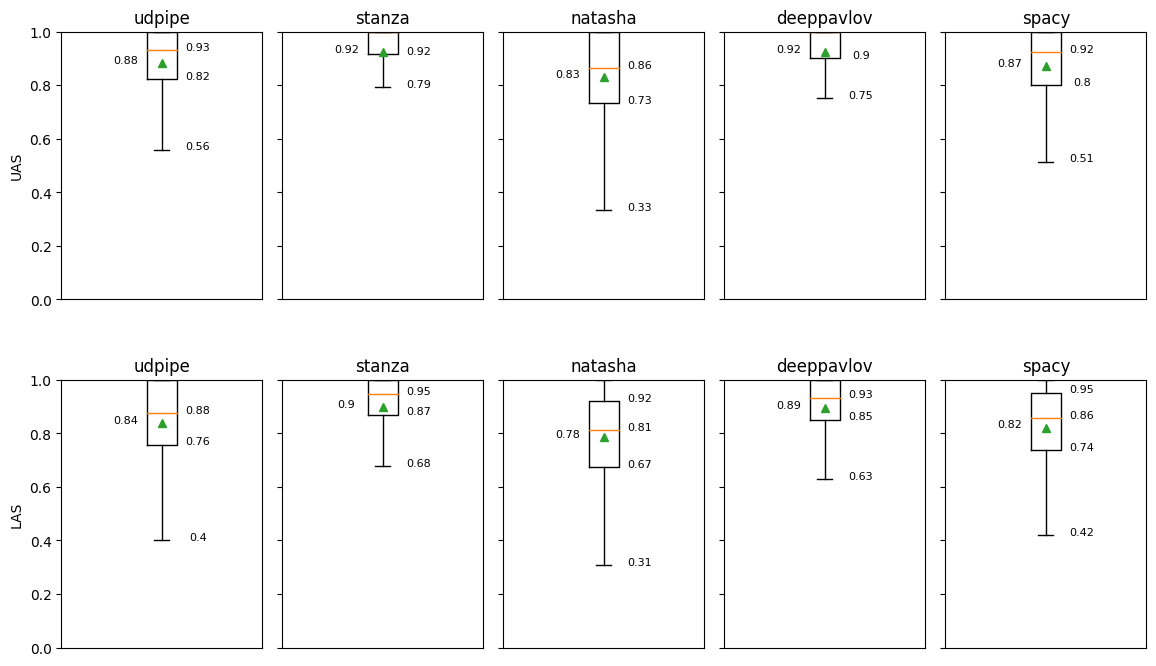

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=len(parser_names), figsize = (14,8), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.3)

#fig.suptitle('aligned uas/aligned las (f-score)')

for col_i, p in enumerate(parser_names):
    b = ax[0][col_i].boxplot(x=align_uas_f[p], showfliers=False,showcaps=True,showmeans=True)
    c = b['caps'][0]._y[0]
    ax[0][col_i].text(
          1.18, # x-coordinate
          c, # y-coordinate
          f'{c:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    u_q1 = align_uas_f[p].quantile(0.25)
    ax[0][col_i].text(
        1.18, # x-coordinate
        u_q1, # y-coordinate
        f'{u_q1:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
    )
    u_q2 = align_uas_f[p].quantile(0.5)
    if u_q2 != 1.0:
      ax[0][col_i].text(
          1.18, # x-coordinate
          u_q2, # y-coordinate
          f'{u_q2:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    u_mean = align_uas_f[p].mean()
    if u_mean != 1.0:
      ax[0][col_i].text(
            0.82, # x-coordinate
            u_mean, # y-coordinate
            f'{u_mean:.2}', # text
            horizontalalignment='center', # centered
            fontsize=8, # small font size
        )
    ax[0][col_i].title.set_text(p)
    ax[0][col_i].set_ylim([0.0, 1.0])
    ax[0][col_i].get_xaxis().set_visible(False)

    b = ax[1][col_i].boxplot(x=align_las_f[p], showfliers=False,showcaps=True,showmeans=True)
    c = b['caps'][0]._y[0]
    ax[1][col_i].text(
          1.18, # x-coordinate
          c, # y-coordinate
          f'{c:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    l_q3 = align_las_f[p].quantile(0.75)
    if l_q3 != 1.0:
      ax[1][col_i].text(
          1.18, # x-coordinate
          l_q3, # y-coordinate
          f'{l_q3:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    l_q2 = align_las_f[p].quantile(0.5)
    if l_q2 != 1.0:
      ax[1][col_i].text(
          1.18, # x-coordinate
          l_q2, # y-coordinate
          f'{l_q2:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    l_q1 = align_las_f[p].quantile(0.25)
    if l_q1 != 1.0:
      ax[1][col_i].text(
          1.18, # x-coordinate
          l_q1, # y-coordinate
          f'{l_q1:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )
    l_mean = align_las_f[p].mean()
    if l_mean != 1.0:
      ax[1][col_i].text(
            0.82, # x-coordinate
            l_mean, # y-coordinate
            f'{l_mean:.2}', # text
            horizontalalignment='center', # centered
            fontsize=8, # small font size
        )
    ax[1][col_i].title.set_text(p)
    ax[1][col_i].set_ylim([0.0, 1.0])
    ax[1][col_i].get_xaxis().set_visible(False)

ax[0, 0].set_ylabel('UAS')
ax[1, 0].set_ylabel('LAS')

plt.savefig('uas_las_boxplot.jpg')
plt.show()

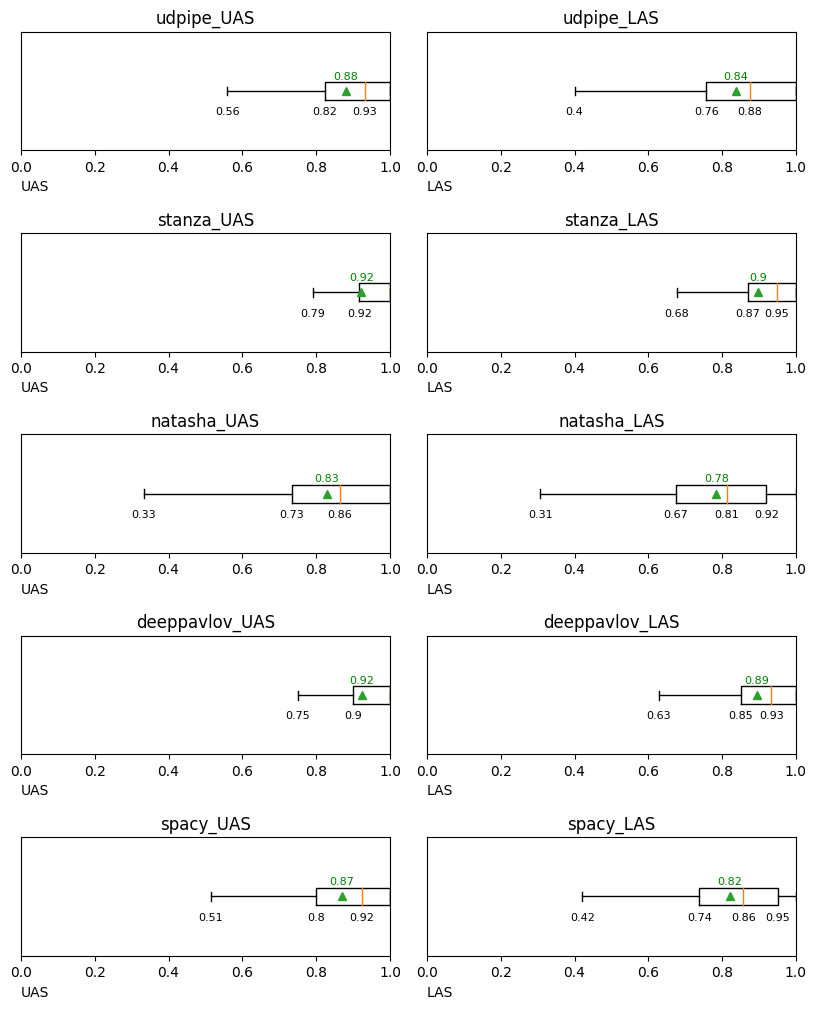

In [ ]:
fig, ax = plt.subplots(nrows=len(parser_names), ncols=2, figsize = (10,12), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.7)

uas_left_border = {}
las_left_border = {}

#fig.suptitle('aligned uas/aligned las (f-score)')

for col_i, p in enumerate(parser_names):
    b = ax[col_i, 0].boxplot(x=align_uas_f[p], showfliers=False,showcaps=True,showmeans=True, vert=False)
    ax[col_i, 0].set_xlabel('UAS', loc='left')
    ax[col_i, 0].set_xlim([0.0, 1.0])
    ax[col_i, 0].get_yaxis().set_visible(False)
    c = b['caps'][0]._x[0]
    uas_left_border[p] = c
    ax[col_i][0].text(
          c, # x-coordinate
          0.8, # y-coordinate
          f'{c:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )

    u_q1 = align_uas_f[p].quantile(0.25)
    ax[col_i][0].text(
        u_q1, # x-coordinate
        0.8, # y-coordinate
        f'{u_q1:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
    )
    u_q2 = align_uas_f[p].quantile(0.5)
    if u_q2 != 1.0:
      ax[col_i][0].text(
        u_q2, # x-coordinate
        0.8, # y-coordinate
        f'{u_q2:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
      )
    u_q3 = align_uas_f[p].quantile(0.75)
    if u_q3 != 1.0:
      ax[col_i][0].text(
        u_q3, # x-coordinate
        0.8, # y-coordinate
        f'{u_q3:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
      )

    u_mean = align_uas_f[p].mean()
    if u_mean != 1.0:
      ax[col_i][0].text(
            u_mean, # x-coordinate
            1.1, # y-coordinate
            f'{u_mean:.2}', # text
            horizontalalignment='center', # centered
            fontsize=8, # small font size
            color='green'
      )
    ax[col_i][0].title.set_text(f"{p}_UAS")

    b = ax[col_i, 1].boxplot(x=align_las_f[p], showfliers=False,showcaps=True,showmeans=True, vert=False)
    ax[col_i, 1].set_xlabel('LAS', loc='left')
    ax[col_i, 1].set_xlim([0.0, 1.0])
    ax[col_i, 1].get_yaxis().set_visible(False)
    c = b['caps'][0]._x[0]
    las_left_border[p] = c
    ax[col_i][1].text(
          c, # x-coordinate
          0.8, # y-coordinate
          f'{c:.2}', # text
          horizontalalignment='center', # centered
          fontsize=8, # small font size
      )

    l_q1 = align_las_f[p].quantile(0.25)
    ax[col_i][1].text(
        l_q1, # x-coordinate
        0.8, # y-coordinate
        f'{l_q1:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
    )

    l_q2 = align_las_f[p].quantile(0.5)
    if l_q2 != 1.0:
      ax[col_i][1].text(
        l_q2, # x-coordinate
        0.8, # y-coordinate
        f'{l_q2:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
      )
    l_q3 = align_las_f[p].quantile(0.75)
    if l_q3 != 1.0:
      ax[col_i][1].text(
        l_q3, # x-coordinate
        0.8, # y-coordinate
        f'{l_q3:.2}', # text
        horizontalalignment='center', # centered
        fontsize=8, # small font size
      )
    l_mean = align_las_f[p].mean()
    if l_mean != 1.0:
      ax[col_i][1].text(
            l_mean, # x-coordinate
            1.1, # y-coordinate
            f'{l_mean:.2}', # text
            horizontalalignment='center', # centered
            fontsize=8, # small font size
            color='green'
      )
    ax[col_i][1].title.set_text(f"{p}_LAS")


plt.savefig('uas_las_boxplot.jpg')
plt.show()

In [ ]:
for p in parser_names:
  print(p, f"{uas_left_border[p]:.2f}", sum(align_uas_f[p] < uas_left_border[p]))

udpipe 0.56 445
stanza 0.79 832
natasha 0.33 115
deeppavlov 0.75 655
spacy 0.51 410


In [ ]:
for p in parser_names:
  print(p, f"{las_left_border[p]:.2f}", sum(align_las_f[p] < las_left_border[p]))

udpipe 0.40 208
stanza 0.68 625
natasha 0.31 143
deeppavlov 0.63 458
spacy 0.42 314
